# Requirements to run

We recommend generatating a new Anaconda environment before trying to run this project.
The reason is that igraph may have dependencies that conflict with your other project configurations.
As a consequence a new Anaconda environment will likely lead to less debugging and conflicting package issues.

### If you miss a dependency
conda install -c conda-forge python-igraph <br/>
conda install -c conda-forge pycairo <br/>
conda install pandas

Note that the correct igraph package is listed at https://igraph.org/python/doc/tutorial/install.html and NOT at anaconda.org!

In [1]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import igraph as igraph
import math
import numpy as np
import os as os

### Check igraph installation 
This is purely for ensuring the package has been installed correctly

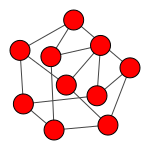

In [2]:
import igraph as ig
g = ig.Graph.Famous("petersen")
ig.plot(g, bbox=(0, 0, 150, 150))

## Currently problematic UIs
10594 reason: mapview where determining observe time is challenging and order of interaction

## Deleted UIs
1996: reason: faulty json missing component for "Home" <br/>
21186 reason: Too many components with clickable flag set incorrectly. <br/>
24701 reason: incorrect clickability labeling <br/>
26150 reason: no clickables set and UI too complicated to reliably mark correct clickables <br/>
26442 reason: too much speculation when determining swipe component <br/>
29058 reason: no proper indicator component for swipeability <br/>
34595 reason: seems to pick up item underneath the drawer <br/>
39015 reason: too much ambiquity with correcting incorrect clickable components <br/>
39334 reason: JSON doesn't match interaction graph structure as perceived by human <br/>
41679 reason: picked elements from underneath calculator widget. <br/>
44718 reason: picked elements from underneath toolbar <br/>

<br/>
11049 reason: charmaps to undefined, faulty coding (font not understood) <br/>
11148 reason: charmaps to undefined, faulty coding (font not understood) <br/>
11150 reason: charmaps to undefined, faulty coding (font not understood)

## Edited JSON files
14310 reason: the text items here are clickable in reality, original version had false <br/>
21545 reason: components not set as  clickable correctly <br/>
23689 reason: pager indicator means there is a swipe component but rico didn't register it as clickable
27046 reason: incorrectly set drawer as clickable when list items are the clickables <br/>
30348 reason: incorrectly set drawer as clickable when list items are the clickables <br/>
33395 reason: clickable text and arrow icons were incorrectly marked to false <br/>
35472 reason: clickable list items were set to false <br/>
36000 reason: clickable text was set to false (looks like text button but might have borders on text element!) <br/>
36999 reason: toolbar was incorrectly set as clickable <br/>
39118 reason: list items incorrectly marked as unclickable <br/>
43387 reason: file download icon was not set as clickable <br/>
44706 reason: incorrect clickables due to Toolbar <br/>
46019 reason: modal text elements not marked as clickables <br/>

# Notes on JSONs
33395: complexity outcome is more complicated due to text-icon split than with list item clickables due to how the interface has been defined. In reality there should be no complexity difference for the user. No action taken as of now. For this issue <br/>

### Component mappings
|Component | Code | Operation |
--- | --- | ---|
|Background Image| BI | Tap |
|Button Bar| BB| Tap|
|Checkbox | C | Tap |
|Card | CC | Tap |
|Icon | I| Tap |
|Input | IP | Input |
|Map View | MV | Multi |
| | | |


In [3]:
#give filename as "id.json"
#1809.json
#546.json

verticesMap = {"Advertisement": "AD",
               "Background Image": "BI",
               "Button Bar": "BB", 
               "Checkbox": "C", 
               "Card": "CC",
               "Date Picker": "DP",
               "Icon": "I", 
               "Image": "IM", 
               "Input": "IP", 
               "List Item": "L", 
               "Map View": "M",
               "On/Off Switch": "S",
               "Pager Indicator": "P",
               "Radio Button": "RB", 
               "Text": "TC", 
               "Text Button": "TB", 
               "Web View": "WV"}

edgesMap = {"AD": "Tap",
            "BB": "Tap",
            "BI": "Tap",
            "C": "Tap", 
            "CC": "Tap",
            "DP": "Multi",
            "I": "Tap", 
            "IM": "Tap", 
            "IP": "Input", 
            "L": "Tap", 
            "M": "Multi",
            "P": "Swipe",
            "RB": "Tap", 
            "S": "Tap",
            "TB": "Tap", 
            "TC": "Tap", 
            "WV": "Tap"} 

doNotEndTask = ["Checkbox", "Date Picker", "Input", "On/Off Switch"]

## Extract components from file

In [4]:
def getNormalizedBounds(dimensions, bounds):
    x1 = bounds[0] / dimensions[2]
    y1 = bounds[1] / dimensions[3]
    x2 = bounds[2] / dimensions[2]
    y2 = bounds[3] / dimensions[3]
    return [x1, y1, x2, y2]

def sortControlComponents(components):
    sortedComponents = []
    for component in components:
        bounds = component[1]
        componentPosition = 0
        for i in range(len(sortedComponents)):
            compareTo = sortedComponents[i]
            compareToBounds = compareTo[1]
            #If the new component is below the previous one then we move 
            #it to towards the end of component ordering
            if bounds[1] > compareToBounds[3]:
                componentPosition += 1
            #if we have overlap between the components we choose by
            #the component ordering in horizontal plane
            elif bounds[0] > compareToBounds[2]:
                componentPosition += 1
            #otherwise we assume that the current component is before the other component
        sortedComponents.insert(componentPosition, component)
    return sortedComponents
        

def getControlComponents(children):
    controlComponents = []
    def loopForControlComponents(children):
        for c in children:
            clickable = c['clickable']
            if(clickable):
                controlComponents.append((clickable, c['bounds'], 
                                          c['componentLabel']))
            elif("children" in c):
                loopForControlComponents(c["children"])
                
    loopForControlComponents(children)
    ccCount = len(controlComponents)
    return controlComponents, ccCount

## Define Matrix Structure
The matrix is defined as such that any connection flowing downwards from a node above is marked in the matrix row that defines the node existing underneat it with a value 1. In other words if the first node flows to the leftmost node below it from the left we have a matrix:<br/>
[[0,0,0],<br/>
 [1,0,0],<br/>
 [0,0,0]]<br/>
 In the above definition one node is not connected to anything.
 If node on second level had a connection to two other nodes underneath it we would define the matrix as:<br/>
 [[0,0,0,0],<br/>
  [1,0,0,0],<br/>
  [0,1,0,0],<br/>
  [0,1,0,0]]<br/>

In [5]:
def defineAdjacencyMatrix(controlComponents, ccCount): 
    adjacencyMatrix =  [[0] * (ccCount+2)]
    endVector = [0] * (ccCount+2) 
    endpointsCounter = ccCount
    #this defines where the next nodes shall form connections
    currentAnchorColumn = 0
    componentLimit = ccCount - 1
    for i in range(ccCount): 
            component = controlComponents[i]
            intermediateVector = []
            
            #special case for filling a login code with automatic UI refresh 
            #when Input field meets required length
            if(component[2] in doNotEndTask and i == componentLimit):
                intermediateVector = [0] * (ccCount+1)
                intermediateVector.insert(currentAnchorColumn, 1)
                currentAnchorColumn = 0
                endVector[i+1] = 1
            elif(component[2] in doNotEndTask):
                intermediateVector = [0] * (ccCount+1) 
                intermediateVector.insert(currentAnchorColumn, 1) 
                currentAnchorColumn = i + 1
                endVector[i+1] = 0
                endpointsCounter -= 1
            else:
                intermediateVector = [0] * (ccCount+1)
                intermediateVector.insert(currentAnchorColumn, 1)
                currentAnchorColumn = 0
                endVector[i+1] = 1
            adjacencyMatrix = adjacencyMatrix + [intermediateVector] 
            #endVector[id+1] = 1
    adjacencyMatrix = adjacencyMatrix + [endVector] 
    print("adjacencymatrix")
    for a in adjacencyMatrix:
        print(a)
    return np.array(adjacencyMatrix), endpointsCounter


def defineVertices(adjacencyMatrix, controlComponents): 
    verticeLabels = ["E"] 
    
    noEndpoints = pd.DataFrame(adjacencyMatrix)
    noEndpoints.drop(0,inplace=True)
    noEndpoints.drop(noEndpoints.tail(1).index,inplace=True)
    print("No endpoints")
    print(noEndpoints)
    layersWithVertices = noEndpoints.sum(axis=0) 
    print("WITH Vertices sum")
    print(layersWithVertices)
    layersWithVertices = layersWithVertices[layersWithVertices != 0]
    print("Some operation not equals zero")
    print(layersWithVertices)
    columnsWithVerticesIndexes = layersWithVertices.index
    print("Extract column pos")
    print(columnsWithVerticesIndexes)
    currentComponentItem = 0
    for i in columnsWithVerticesIndexes:
        currentColumn = adjacencyMatrix[:, i]
        for row, c in enumerate(currentColumn):
            if c == 1:
                currentItem = controlComponents[currentComponentItem][2]
                #These form the base level of the graph and other components are inserted around these
                #to match the order required by igraph
                if(i == 0):
                    verticeLabels.append(verticesMap[currentItem])
                else:
                    verticeLabels.insert(row-1, verticesMap[currentItem])
                currentComponentItem += 1

    #verticesPerLayer= layersWithVertices.iloc[layersWithVertices.to_numpy().nonzero()[0]].to_numpy()
    #for c in controlComponents: 
    #    if(c[2] in verticesMap): 
    #        print("c", c[2], "v", verticesMap[c[2]])
    #        verticeLabels = verticeLabels + [verticesMap[c[2]]]
    #verticeLabels = ["E"] + verticeLabels 
    verticeLabels = verticeLabels + ["S"] 
    return verticeLabels 

def defineEdges(adjacencyMatrix, verticeLabels, endpointCount):
    edgeLabels = []

    #edgesPerLayer.loc[:, (edgesPerLayer != 0).any(axis=0)]
    #print("--")
    #print(noEndpoints)
    #print("--")
    #print(edgesPerLayer)
    
    #currentEdgeGroup = 0
    workedThroughGroupItems = 0
    for v in range(len(verticeLabels)-1):
        if(verticeLabels[v] in edgesMap):
            
            edgeLabels = edgeLabels + [edgesMap[verticeLabels[v]]]
            #currentEdge = 0
        elif(verticeLabels[v] == "E"):
            edgeLabels = (["O"]*endpointCount) + edgeLabels
    #for v in range(len(verticeLabels)-1,-1,-1):
    #    print("V is", v, verticeLabels[v])
    #    if(verticeLabels[v] in edgesMap):
    #        edgeLabels = edgeLabels + [edgesMap[verticeLabels[v]]]
    #    elif(verticeLabels[v] == "E"):
    #        edgeLabels = (["O"]*endpointCount) + edgeLabels
    return edgeLabels

## Complexity Computations

In [6]:
def computeHalstead(edgeLabels, verticeLabels):
    #number of unique operators
    n1 = len(set(edgeLabels))
    #number of unique operands. We remove start and end
    n2 = len(set(verticeLabels))-2
    #total frequency of operators
    N1 = len(edgeLabels)
    #total frequency of operands. We remote start and end 
    N2 = len(verticeLabels)-2
    
    firstPart = (n1*N2*(N1+N2))/(2*n2)
    logPart = math.log(n1+n2, 2)
    #rounded to S significant numbers
    return round(firstPart*logPart,3)


def computeMcCabeVG(adjacencyMatrix):
    nodes = len(adjacencyMatrix)
    #vertices = 0
    edges = adjacencyMatrix.sum().sum()
   # for a in adjacencyMatrix:
    #    print(a)
    #    vertices += a.count(1)
    return nodes - edges

#called from computeWoodEntropy()
def woodComponentComplexity(adjacencyMatrix):
    print("xx")

def computeWoodEntropy(adjacencyMatrix):
    #print("type", type(adjacencyMatrix))
    print("")

## Call function and visualization

In [7]:
def getFile(fileName):
    data = json.load(open("hierarchies/"+fileName, encoding="utf-8"))
    dimensions = data['bounds']
    children = data['children']
    return dimensions, children

def visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, manualTest=False):
    directed = ig.Graph.Adjacency(adjacencyMatrix, mode="directed") 
    directed.vs["label"] = verticeLabels
    directed.vs["color"] = "white"
    directed.es["label"] = edgeLabels
    #directed.es["curved"] = seq(-0.5, 0.5, length = ecount(directed))
    directed.es["curved"] = False
    layout = directed.layout("rt")
    #save to file
    #return as a plot for a jupyter cell
    if(manualTest == True):
        return ig.plot(directed,  layout=layout, bbox=(0, 0, 350, 350), margin=20)
    
    ig.plot(directed, "graphs/"+fileName[:-5]+".png", layout=layout, bbox=(0, 0, 800, 800), margin=20)
    return
 

def determineControlGraphForFile(file):
    dimensions, children = getFile(file)
    controlComponents, ccCount = getControlComponents(children)
    #we need to sort control components as they are not always
    #in a sensible order from the perspective of how the actions would be performed
    sortedControlComponents = sortControlComponents(controlComponents)
    adjacencyMatrix, endpointCount = defineAdjacencyMatrix(sortedControlComponents, ccCount)
    verticeLabels = defineVertices(adjacencyMatrix, sortedControlComponents)
    edgeLabels = defineEdges(adjacencyMatrix, verticeLabels, endpointCount)

    #complexity computation
    halstead = computeHalstead(edgeLabels, verticeLabels)
    mcCabe = computeMcCabeVG(adjacencyMatrix)
    wood = computeWoodEntropy(adjacencyMatrix)
    print("Halstead", halstead, "McCabe", mcCabe, "Wood", wood)
    return adjacencyMatrix, verticeLabels, edgeLabels

## Generate graphs for all json files

In [8]:
def listAllFiles(folderPath):
    return os.listdir(folderPath)

def loopAllJsonFiles(folderPath):
    allFiles = listAllFiles(folderPath)
    for f in allFiles:
        print("------------")
        print("Starting file", f)
        print("------------")
        adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(f)
        visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, f)

In [9]:
loopAllJsonFiles("hierarchies")

------------
Starting file 10128.json
------------
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 19.02 McCabe 0 Wood None
------------
Starting file 10180.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    5
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 58.048 McCabe -3 Wood None
------------
Starting file 10183.json
---

------------
Starting file 10596.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11  12  13  14
1    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
3    1   0   0   0   0   0   0   0   0   

adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0  0
8  1  0  0  0  0  0  0  0  0  0
WITH Vertices sum
0    8
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64
Some operation not equals zero
0    8
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 148.603 McCabe -6 Wood None
------------
Starting file 11082.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]


------------
Starting file 11658.json
------------
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 27.0 McCabe -1 Wood None
------------
Starting file 11712.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8
1  1  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0
WITH V

adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8
1  1  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0
WITH Vertices sum
0    7
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64
Some operation not equals zero
0    7
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 94.997 McCabe -5 Wood None
------------
Starting file 12581.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3

------------
Starting file 12952.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 48.0 McCabe -2 Wood None
------------
Starting file 12954.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 37.151 McCabe -2 Wo

adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 12.0 McCabe 0 Wood None
------------
Starting file 13734.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 37.151 McCabe -2 Wood None
------------
Starting file 13829.json
------------
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: 

adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 48.0 McCabe -2 Wood None
------------
Starting file 14585.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
    0   1   2   3   4   

adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 19.02 McCabe 0 Wood None
------------
Starting file 15065.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0]
[0, 1, 1, 0, 0, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  0  0  0  1  0  0  0
5  0  0  0  0  1  0  0
WITH Vertices sum
0    3
1    0
2    0
3    1
4    1
5    0
6    0
dtype: int64
Some operation not equals zero
0    3
3    1
4    1
dtype: int64
Extract column pos
Int64Index([0, 3, 4], dtype='int64')

Halstead 84.011 McCabe -1 Wood None
------------
Starting file 15095.json
------------
adjacencymatrix
[0, 0

WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    5
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 58.048 McCabe -3 Wood None
------------
Starting file 15574.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    5
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 58.048 McCabe -3 Wood None
------------
Starting file 15631.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11  12
1    1   0   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0   0
3    1   0   0   0   0   0   0   0   0   0   0   0   0
4    1   0   0   0   0   0   0   0   0   0   0   0   0
5    1   0   0   0   0   0   0   0   0   0   0   0   0
6    0   0   0   0   0   1   0   0   0   0   0   0   0
7    1   0   0   0   0   0   0   0   0   0   0   0   0
8    0   0   0   0   0   0 

5  1  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    5
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 58.048 McCabe -3 Wood None
------------
Starting file 16741.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 48.0 McCabe -2 Wood None
------------
Starting file 16766.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3 

2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 12.0 McCabe 0 Wood None
------------
Starting file 17155.json
------------
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 12.0 McCabe 0 Wood None
------------
Starting file 17346.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

------------
Starting file 18483.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11  12  13  14
1    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
3    1   0   0   0   0   0   0   0   0   

9   1   0   0   0   0   0   0   0   0   0   0
WITH Vertices sum
0     6
1     1
2     1
3     1
4     0
5     0
6     0
7     0
8     0
9     0
10    0
dtype: int64
Some operation not equals zero
0    6
1    1
2    1
3    1
dtype: int64
Extract column pos
Int64Index([0, 1, 2, 3], dtype='int64')

Halstead 279.176 McCabe -4 Wood None
------------
Starting file 18869.json
------------
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 1, 0, 0]
[0, 1, 0, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  0  0  1  0  0
WITH Vertices sum
0    2
1    0
2    1
3    0
4    0
dtype: int64
Some operation not equals zero
0    2
2    1
dtype: int64
Extract column pos
Int64Index([0, 2], dtype='int64')

Halstead 41.795 McCabe 0 Wood None
------------
Starting file 18929.json
------------
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype

------------
Starting file 19413.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0   1   2   3   4   5   6   7   8   9   10
1   1   0   0   0   0   0   0   0   0   0   0
2   0   1   0   0   0   0   0   0   0   0   0
3   1   0   0   0   0   0   0   0   0   0   0
4   1   0   0   0   0   0   0   0   0   0   0
5   1   0   0   0   0   0   0   0   0   0   0
6   1   0   0   0   0   0   0   0   0   0   0
7   1   0   0   0   0   0   0   0   0   0   0
8   1   0   0   0   0   0   0   0   0   0   0
9   1   0   0   0   0   0   0   0   0   0   0
WITH Vertices sum
0     8
1     1
2     0
3     0
4     0
5     0
6     0
7     0
8   

adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 4.755 McCabe 1 Wood None
------------
Starting file 20147.json
------------
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 42.794 McCabe -1 Wood None
------------
Starting file 20164.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5

------------
Starting file 20488.json
------------
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 20.897 McCabe 0 Wood None
------------
Starting file 20518.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]
No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11
1    1   0   0   0   0   0   0   0   0   0   0   0
2   

------------
Starting file 21230.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0   1   2   3   4   5   6   7   8   9   10
1   1   0   0   0   0   0   0   0   0   0   0
2   1   0   0   0   0   0   0   0   0   0   0
3   0   0   1   0   0   0   0   0   0   0   0
4   1   0   0   0   0   0   0   0   0   0   0
5   1   0   0   0   0   0   0   0   0   0   0
6   1   0   0   0   0   0   0   0   0   0   0
7   1   0   0   0   0   0   0   0   0   0   0
8   1   0   0   0   0   0   0   0   0   0   0
9   1   0   0   0   0   0   0   0   0   0   0
WITH Vertices sum
0     8
1     0
2     1
3     0
4     0
5     0
6     0
7     0
8   

------------
Starting file 2170.json
------------
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 20.897 McCabe -1 Wood None
------------
Starting file 2175.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8
1  1  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0
WITH Vertices sum
0    7
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64
Some operation not equals zero
0    7
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 147.0 McCabe -5 Wood None
------------
Starting file 22082.json
------------
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1  

------------
Starting file 22730.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0  0  0  0
2  0  1  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0  0
8  1  0  0  0  0  0  0  0  0  0
WITH Vertices sum
0    7
1    1
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64
Some operation not equals zero
0    7
1    1
dtype: int64
Extract column pos
Int64Index([0, 1], dtype='int64')

Halstead 193.707 McCabe -5 Wood None
------------
Starting file 22748.json
------------
adjacencymatrix
[0, 0

adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 20.897 McCabe -1 Wood None
------------
Starting file 23689.json
------------
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 4.755 McCabe 1 Wood None
------------
Starting file 23735.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[1, 0, 0, 0, 0,

------------
Starting file 23823.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8
1  1  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0
WITH Vertices sum
0    7
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64
Some operation not equals zero
0    7
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 94.997 McCabe -5 Wood None
------------
Starting file 23853.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 

------------
Starting file 24687.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7
1  1  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0
WITH Vertices sum
0    6
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64
Some operation not equals zero
0    6
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 108.0 McCabe -4 Wood None
------------
Starting file 24745.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7
1  1  0 

adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    5
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 75.0 McCabe -3 Wood None
------------
Starting file 25069.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

------------
Starting file 25635.json
------------
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 42.794 McCabe -1 Wood None
------------
Starting file 25658.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 48.0 McCabe -2 Wood None
------------
Starting file 2573.json
------------
adjacencymatrix

adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 48.0 McCabe -2 Wood None
------------
Starting file 26979.json
------------
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 4.755 McCabe 1 Wood None
------------
Starting file 27007.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0,

------------
Starting file 27664.json
------------
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 4.755 McCabe 1 Wood None
------------
Starting file 27733.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7
1  1  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0
3  0  0  1  0  0  0  0  0
4  1  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    1
3    0
4    0
5    0
6    0
7    0
dtype: int64
Some operation not equals zero
0    5
2    1
dtype: int64
Extract column pos
Int64Index([0, 2], dtype='int64')

Halstead 131.833 Mc

adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7
1  1  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0
WITH Vertices sum
0    6
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64
Some operation not equals zero
0    6
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 108.0 McCabe -4 Wood None
------------
Starting file 28120.json
------------
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 19.02 McCabe 0 Wood N

No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 42.794 McCabe -1 Wood None
------------
Starting file 28593.json
------------
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 4.755 McCabe 1 Wood None
------------
Starting file 28646.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    

------------
Starting file 295.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11
1    1   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0
3    1   0   0   0   0   0   0   0   0   0   0   0
4    1   0   0   0   0   0   0   0   0   0   0   0
5    1   0   0   0   0   0   0   0   0   0   0   0
6    1   0   0   0   0   0   0   0   0   0   0   0
7    1   0   0   0   0   0   0   0   0   0   0   0
8    1   0   0   0   0   0   0   0   0   0   0   0
9    1   0   0   0 

Starting file 30240.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 76.078 McCabe -2 Wood None
------------
Starting file 30259.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0

adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0  0
4  0  0  0  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0  0
8  1  0  0  0  0  0  0  0  0  0
WITH Vertices sum
0    7
1    0
2    0
3    1
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64
Some operation not equals zero
0    7
3    1
dtype: int64
Extract column pos
Int64Index([0, 3], dtype='int64')

Halstead 193.707 McCabe -5 Wood None
------------
Starting file 30652.json
------------
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1 

adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11  12  13
1    1   0   0   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0   0   0
3    1   0   0   0   0   0   0   0   0   0   0   0   0   0
4    1   0   0   0   0   0   0   0   0   0   0   0   0   0
5    1   0   0   0   0   0   0   0   0   0   0   0   0   0
6    1   0   0 

adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 12.0 McCabe 0 Wood None
------------
Starting file 32361.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0   1   2   3   4   5   6   7   8   9   10
1   1   0   0   0   0   0   0   0   0   0   0
2   1   0   0   0   0   0   0   0   0   0   0
3   1   0   0   0   0   0   0   0   0   0   0
4   1   0   0   0   0   0   0   0   0   0   0

    0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
1    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
5    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
6    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
7    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
8    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
9    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
10   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
11   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
12   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0  

adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 12.0 McCabe 0 Wood None
------------
Starting file 33709.json
------------
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 19.02 McCabe 0 Wood None
------------
Starting file 33763.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 4.755 McCabe 1 Wood None
------------
Starting file 34344.json
------------
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 19.02 McCabe 0 Wood None
------------
Starting file 34351.json
------------
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column po

------------
Starting file 34978.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8
1  1  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0
WITH Vertices sum
0    7
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64
Some operation not equals zero
0    7
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 113.774 McCabe -5 Wood None
------------
Starting file 34981.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 

adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7
1  1  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0
WITH Vertices sum
0    6
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64
Some operation not equals zero
0    6
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 171.176 McCabe -4 Wood None
------------
Starting file 35557.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0,

------------
Starting file 35871.json
------------
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 4.755 McCabe 1 Wood None
------------
Starting file 35993.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0   1   2   3   4   5   6   7   8   9   10
1   1   0   0   0   0   0   0   0   0   0   0
2   1   0   0   0   0   0   0   0   0   0   0
3   1   0   0   0   0   0   0   0   0   0   0
4   1   0   0   0   0   0   0   0   0   0 

------------
Starting file 36745.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11  12  13
1    1   0   0   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0   0   0
3    1   0   0   0   0   0   0   0   0   0   0   0   0   0
4    1   0   0   0   0   0   0   0   0   0   0   0   0   0
5    1   0   0   0   0 

   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  0  0  1  0  0  0
4  0  0  0  1  0  0
WITH Vertices sum
0    2
1    0
2    1
3    1
4    0
5    0
dtype: int64
Some operation not equals zero
0    2
2    1
3    1
dtype: int64
Extract column pos
Int64Index([0, 2, 3], dtype='int64')

Halstead 60.0 McCabe 0 Wood None
------------
Starting file 37078.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 0, 1, 0, 0, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0  0
4  0  0  0  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0  0
6  0  0  0  0  0  1  0  0  0  0
7  0  0  0  0  0  0  1  0  0  0
8  1  0  0  0  0  0  0  0 

adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    5
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 96.936 McCabe -3 Wood None
------------
Starting file 37738.json
------------
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 4.755 McCabe 1 Wood None
------------
Starting file 37879.json
------------
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  

adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 76.078 McCabe -2 Wood None
------------
Starting file 38250.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0

adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11  12  13
1    1   0   0   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0   0   0
3    1   0   0   0   0   0   0   0   0   0   0   0   0   0
4    1   0   0   0   0   0   0   0   0   0   0   0   0   0
5    1   0   0   0   0   0   0   0   0   0   0   0   0   0
6    1   0   0 

adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0]
No endpoints
   0   1   2   3   4   5   6   7   8   9   10
1   1   0   0   0   0   0   0   0   0   0   0
2   1   0   0   0   0   0   0   0   0   0   0
3   1   0   0   0   0   0   0   0   0   0   0
4   0   0   0   1   0   0   0   0   0   0   0
5   1   0   0   0   0   0   0   0   0   0   0
6   1   0   0   0   0   0   0   0   0   0   0
7   0   0   0   0   0   0   1   0   0   0   0
8   1   0   0   0   0   0   0   0   0   0   0
9   1   0   0   0   0   0   0   0   0   0   0
WITH Vertices sum
0     7
1     0
2     0
3     1
4     0
5     0
6     1
7     0
8     0
9     0
10    0
dtype: int64
Some operation not

adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 4.755 McCabe 1 Wood None
------------
Starting file 39606.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8
1  1  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0
WITH Vertices sum
0    7
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64
Some operation not equals zero
0    7
dtype: int64
Extract column pos
Int

adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 19.02 McCabe 0 Wood None
------------
Starting file 40361.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8
1  1  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0
WITH Vertices sum
0    7
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64
Some operation not equal

Starting file 41127.json
------------
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 27.0 McCabe -1 Wood None
------------
Starting file 41174.json
------------
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 20.897 McCabe -1 Wood None
------------
Starting file 41206.json
------------
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0

adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    5
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 75.0 McCabe -3 Wood None
------------
Starting file 41932.json
------------
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 12.0 McCabe 0 Wood None
------------
Starting file 41937.json
------------
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0,

------------
Starting file 42456.json
------------
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 19.02 McCabe 0 Wood None
------------
Starting file 42468.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 

------------
Starting file 43093.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 48.0 McCabe -2 Wood None
------------
Starting file 43186.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0,

------------
Starting file 43478.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11  12  13
1    1   0   0   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0   0   0
3    1   0   0   0   0   0   0   0   0   0   0   0   0   0
4    1   0   0   0   0   0   0   0   0   0   0   0   0   0
5    1   0   0   0   0 

adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 12.0 McCabe 0 Wood None
------------
Starting file 44150.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8
1  1  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0
WITH Vertices sum
0    7
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64
Some operation not equals

adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 42.794 McCabe -1 Wood None
------------
Starting file 44778.json
------------
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 19.02 McCabe 0 Wood None
------------
Starting file 44818.json
------------
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0   

------------
Starting file 45182.json
------------
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0   1   2   3   4   5   6   7   8   9   10
1   1   0   0   0   0   0   0   0   0   0   0
2   1   0   0   0   0   0   0   0   0   0   0
3   1   0   0   0   0   0   0   0   0   0   0
4   1   0   0   0   0   0   0   0   0   0   0
5   1   0   0   0   0   0   0   0   0   0   0
6   1   0   0   0   0   0   0   0   0   0   0
7   1   0   0   0   0   0   0   0   0   0   0
8   1   0   0   0   0   0   0   0   0   0   0
9   1   0   0   0   0   0   0   0   0   0   0
WITH Vertices sum
0     9
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8   

adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15
1    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0   

ZeroDivisionError: division by zero

# Manual Test Section To Improve Code

### ID 2789

adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 0, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  0  0  1  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    3
1    0
2    1
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    3
2    1
dtype: int64
Extract column pos
Int64Index([0, 2], dtype='int64')

Halstead 56.869 McCabe -1 Wood None
['E', 'I', 'TB', 'IP', 'TB', 'S']
['O', 'O', 'O', 'Tap', 'Tap', 'Input', 'Tap']


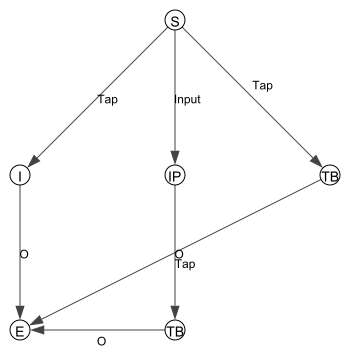

In [10]:
fileName = "1074.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 44719

adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8
1  1  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0
WITH Vertices sum
0    7
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64
Some operation not equals zero
0    7
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

Halstead 147.0 McCabe -5 Wood None
['E', 'I', 'L', 'L', 'L', 'L', 'L', 'L', 'S']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'Tap', 'Tap', 'Tap', 'Tap', 'Tap', 'Tap', 'Tap']


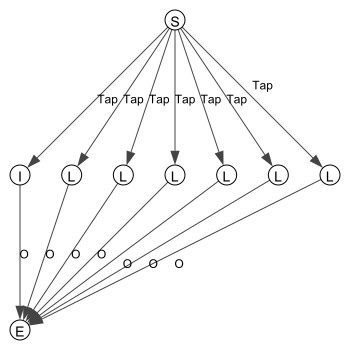

In [10]:
fileName = "44719.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 44718

In [ ]:
fileName = "44718.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 44706

In [ ]:
fileName = "44706.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 41937

In [ ]:
fileName = "41937.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 39118

In [ ]:
fileName = "39118.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 37073

In [ ]:
fileName = "37073.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 34595

In [ ]:
fileName = "34595.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 23689

In [ ]:
fileName = "23689.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 21545

In [ ]:
fileName = "21545.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 20891 

In [ ]:
fileName = "20891.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 1996
Outcome: deleted due to faulty json

In [ ]:
fileName = "1996.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 17467

In [ ]:
fileName = "17467.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 14310

adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 0]

Halstead 171.176 McCabe -4 Wood None
['E', 'TC', 'TC', 'TC', 'TC', 'TC', 'TC', 'S']
['O', 'O', 'O', 'O', 'O', 'O', 'Tap', 'Tap', 'Tap', 'Tap', 'Tap', 'Tap']


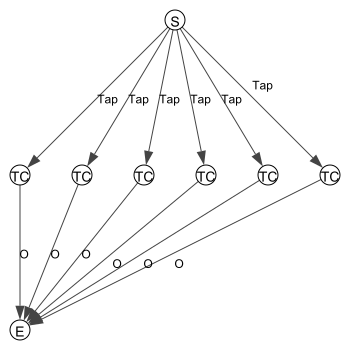

In [10]:
fileName = "14310.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 10594

adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]

Halstead 20.897 McCabe 0 Wood None
['E', 'M', 'TB', 'S']
['O', 'O', 'Multi', 'Tap']


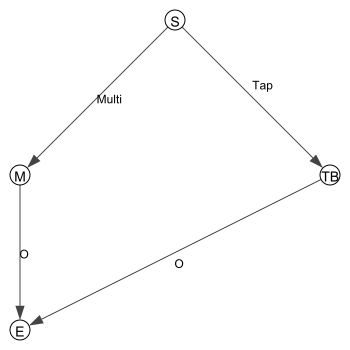

In [9]:
fileName = "10594.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 10482 computation

adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]

Halstead 20.897 McCabe 0 Wood None
['E', 'I', 'IP', 'S']
['O', 'O', 'Tap', 'Input']


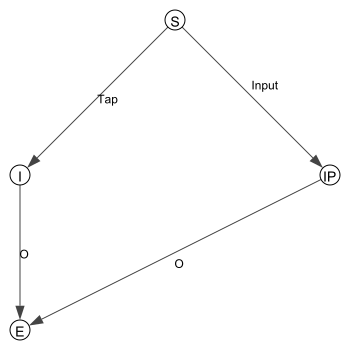

In [24]:
fileName = "10482.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 1809 computation

adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]

Halstead 4.755 McCabe 1 Wood None
['E', 'TB', 'S']
['O', 'Tap']


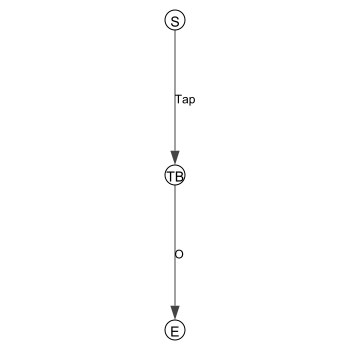

In [11]:
fileName = "1809.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

## Id 492 computation

adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0]
[0, 1, 1, 1, 1, 0, 1, 0]

Halstead 131.833 McCabe -3 Wood None
['E', 'I', 'I', 'TB', 'I', 'TB', 'IP', 'S']
['O', 'O', 'O', 'O', 'O', 'Tap', 'Tap', 'Tap', 'Tap', 'Tap', 'Input']


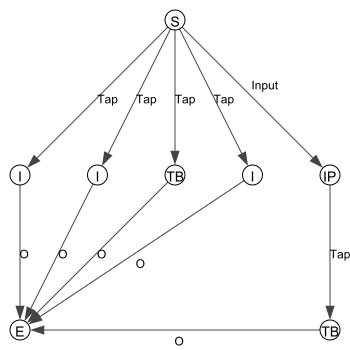

In [17]:
fileName = "492.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 1863 computation

adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]

Halstead 27.0 McCabe -1 Wood None


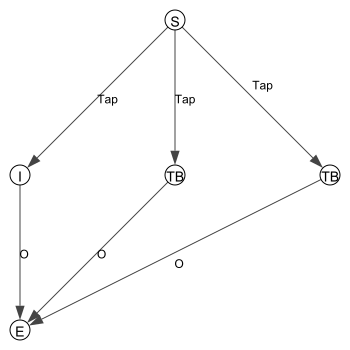

In [19]:
fileName = "1863.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 546 computation

adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]

Halstead 48.0 McCabe -2 Wood None


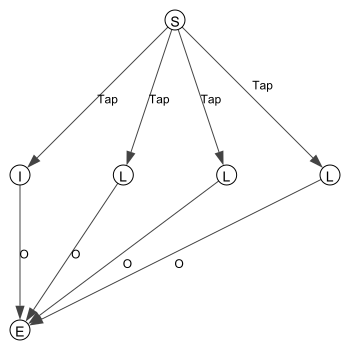

In [20]:
fileName = "546.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 758 computation

adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0]

Halstead 147.0 McCabe -5 Wood None


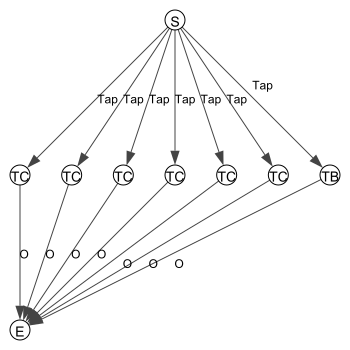

In [21]:
fileName = "758.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 10596 computation

adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]

Halstead 507.0 McCabe -11 Wood None


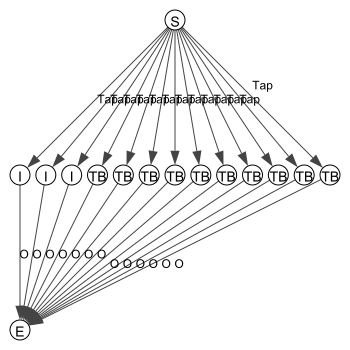

In [22]:
fileName = "10596.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 1074 Computation

adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 0, 1, 1, 0]

Halstead 56.869 McCabe -1 Wood None


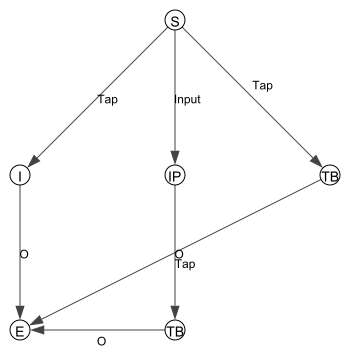

In [23]:
fileName = "1074.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)